# hodgkin–huxley model

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
plt.style.use(plt.style.available[0])
%matplotlib inline

Define the constants and the time step of ODE

# The 4 equations of the Hodgkin-Huxley model  

($V$: Membrane Potential)

* $C_M\displaystyle \frac{dV}{dt}=-g_{Na}\;\;(V-V_{Na})-g_k\;\;(V-V_K)-g_l\;\;(V-V_l)+I$   


($h$: Na Inactivation)  

* $\displaystyle \frac{dh}{dt}=\alpha_h{(V)}\;\;(1-h)-\beta_h(V)h$ 


($m$: Na Activation) 

* $\displaystyle \frac{dm}{dt}=\alpha_m{(V)}\;\;(1-m)-\beta_m(V)m$ 


($n$: K Activation)  

* $\displaystyle \frac{dn}{dt}=\alpha_n{(V)}\;\;(1-n)-\beta_n(V)n$ 

In [3]:
def dv(v, param, dt, par_dict):
    
    C_m = par_dict['C_m']
    G_Na = par_dict['G_Na']
    G_K = par_dict['G_K']
    G_L = par_dict['G_L']
    E_Na = par_dict['E_Na']
    E_K = par_dict['E_K']
    E_L = par_dict['E_L']
    
    
    
    
    h, m, n, i = param
    gna = G_Na * h * (m**3)
    gk = G_K * (n**4)
    gl = G_L
    ina = gna * (v - E_Na)
    ik = gk * (v - E_K)
    il = gl * (v - E_L)
    return (- ina - ik - il + i) * dt / C_m

def dh(h, param, dt, par_dict):
    v = param
    alph = 0.07 * np.exp(-v / 20)
    beth = 1. / (np.exp((30 - v) / 10) + 1)
    return (alph * (1 - h) - beth * h) * dt

def dm(m, param, dt, par_dict):
    v = param
    alpm = 0.1 * (25 - v) / (np.exp((25 - v) / 10) - 1)
    betm = 4. * np.exp(-v / 18)
    return (alpm * (1 - m) - betm * m) * dt

def dn(n, param, dt, par_dict):
    v = param
    alpn = 0.01 * (10 - v) / (np.exp((10 - v) / 10) - 1)
    betn = 0.125 * np.exp(-v / 80)
    return (alpn * (1 - n) - betn * n) * dt

Update the variables by Runge–Kutta method

In [4]:
def rk4(f, y, param, dt, par_dict):
    k1 = f(y, param, dt, par_dict)
    k2 = f(y + dt * k1 * 0.5, param, dt, par_dict)
    k3 = f(y + dt * k2 * 0.5, param, dt, par_dict)
    k4 = f(y + dt * k3, param, dt, par_dict)
    return (k1 + 2*k2 + 2*k3 + k4) / 6

def update(v, m, h, n, i, dt, par_dict):
    v += rk4(dv, v, (h, m, n, i), dt, par_dict)
    m += rk4(dm, m, v, dt, par_dict)
    h += rk4(dh, h, v, dt, par_dict)
    n += rk4(dn, n, v, dt, par_dict)
    return v, m, h, n

Initialize the variables

In [5]:
def run_simulation(
    ### simulation parameters ###
   
    dt = 0.01,      # time step (ms)
    T = 70,       # total running time (ms)
    
    
    ### model paramters ###
    C_m = 1.,       # membrane capacitance (micro F/cm**2)
    
    # Sodium Channel
    G_Na = 120.,    # max Na conductance (mS/cm**2)
    E_Na = 115.,    # Na reversal potential (mV)
    
    # Kalium Channel
    G_K = 40.,      # max K conductance (mS/cm**2)
    E_K = -12.0,    # K reversal potential (mV)
    
    # Leak current    
    G_L = 0.24,     # max leak onductance (mS/cm**2)
    E_L = 10.613,   # leak potential (mV)
    ):
    
    par_dict = dict(
    C_m = C_m,
    G_Na = G_Na,
    E_Na = E_Na,
    G_K  = G_K,
    E_K  = E_K,
    G_L  = G_L,
    E_L  = E_L,
    )
    # initialize the simulation parameters
    V_m = 0 # membrane potential (mV)
    m_Na = 0 # Na channel activation (dimensionless)
    h_Na = 0 # Na channel inactivation (dimensionless)
    n_K = 0 # K channel activation (dimensionless)

    # total membrane current (microA/cm**2) for the time of the simulation
    
    I_input = np.array([0] * int(T/dt))
    I_input[1500:1800] = 10
    Time = [ii*dt for ii in range(int(T/dt))]


    result_V_m, result_m_Na, result_h_Na, result_n_K = ([] for i in range(4))
    for t in range(int(100 // dt)):
        V_m, m_Na, h_Na, n_K = update(v=V_m, m=m_Na, h=h_Na, n=n_K, i=0, dt=dt, par_dict = par_dict)
    for t in range(len(I_input)):
        V_m, m_Na, h_Na, n_K = update(v=V_m, m=m_Na, h=h_Na, n=n_K, i=I_input[t], dt=dt, par_dict = par_dict)
        result_V_m.append(V_m)
        result_m_Na.append(m_Na)
        result_h_Na.append(h_Na)
        result_n_K.append(n_K)
    return result_V_m, result_m_Na, result_h_Na, result_n_K, I_input, Time

Define membrane current

In [6]:
def plot_current(Time, Current):
    plt.subplots(figsize = [12,5])
    plt.xlabel('$t$ (ms)')
    plt.ylabel('$I$ $\mathrm{(\mu A/cm^2)}$')
    # plt.xlim(-1, 30)
    plt.ylim(-2, 12)
    plt.plot(Time, Current)
    plt.title('Input Current $I$')
    plt.savefig('1current.png', dpi=144)
    
def plot_membrane_potential(Time, Voltage):

    plt.subplots(figsize = [12,5])
    plt.xlabel('$t$ (ms)')
    plt.ylabel('$V$ (mV)')
    plt.ylim(-20, 120)
    plt.plot(Time, Voltage, color = '#bd0026')
    title = plt.title('Membrane Potential $V$')

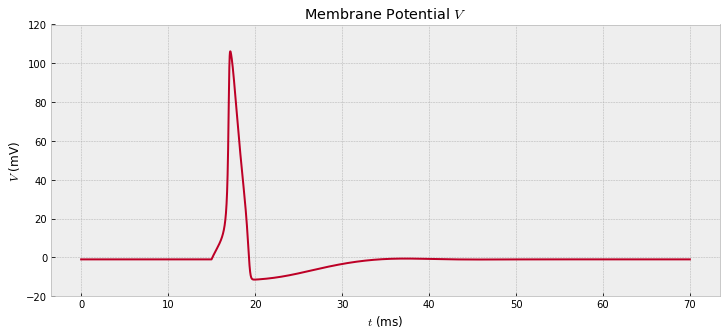

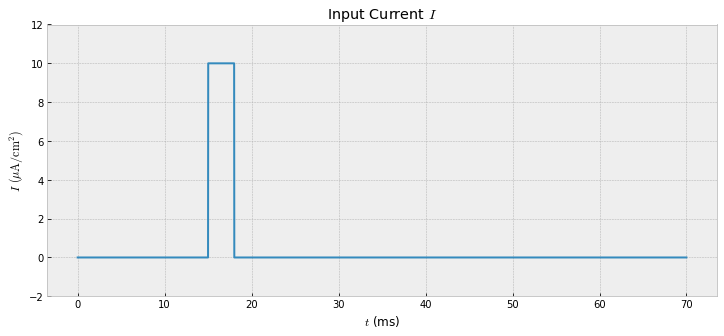

In [7]:
a,b,c,d,e,t = run_simulation()

plot_membrane_potential(Time = t, Voltage = a)
plot_current(Time = t, Current = e)



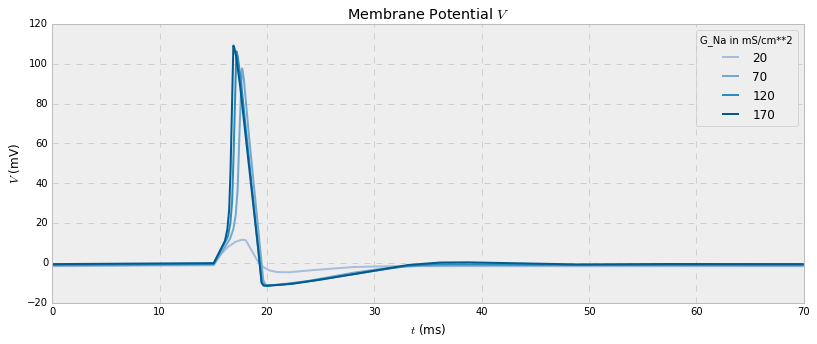

In [231]:
fig, ax = plt.subplots(figsize = [12,5])
colors = ['#a6bddb','#74a9cf','#2b8cbe','#045a8d']
for color, G_Na in zip(colors,[20,70, 120, 170]):
    V_membrane,_,_,_,_,Time = run_simulation(G_Na = G_Na)
    ax.plot(Time, V_membrane, color = color, label = f"{G_Na}")
    
    
ax.set_xlabel('$t$ (ms)')
ax.set_ylabel('$V$ (mV)')
ax.set_ylim(-20, 120)
title = plt.title('Membrane Potential $V$')
ax.legend(title = "G_Na in mS/cm**2" )

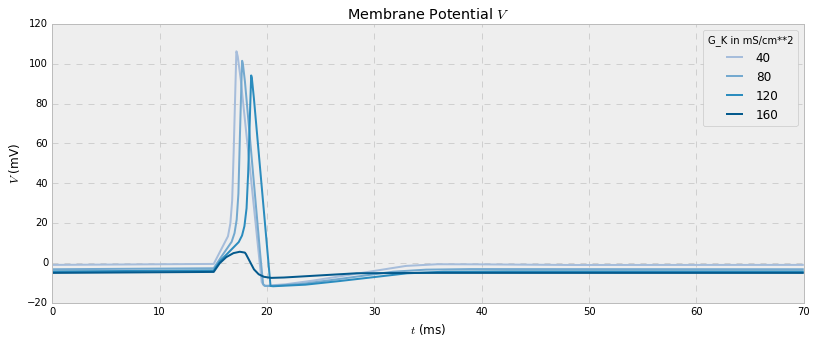

In [230]:
fig, ax = plt.subplots(figsize = [12,5])
colors = ['#a6bddb','#74a9cf','#2b8cbe','#045a8d']
for color, G_K in zip(colors,[40,80, 120, 160]):
    V_membrane,_,_,_,_,Time = run_simulation(G_K = G_K)
    ax.plot(Time, V_membrane, color = color, label = f"{G_K}")
    
    
ax.set_xlabel('$t$ (ms)')
ax.set_ylabel('$V$ (mV)')
ax.set_ylim(-20, 120)
title = plt.title('Membrane Potential $V$')
ax.legend(title = "G_K in mS/cm**2" )

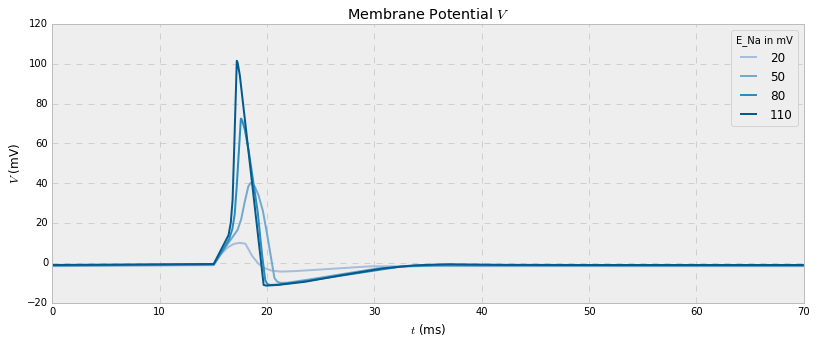

In [233]:
fig, ax = plt.subplots(figsize = [12,5])
colors = ['#a6bddb','#74a9cf','#2b8cbe','#045a8d']
for color, E_Na in zip(colors,[20,50, 80, 110]):
    V_membrane,_,_,_,_,Time = run_simulation(E_Na = E_Na)
    ax.plot(Time, V_membrane, color = color, label = f"{E_Na}")
    
    
ax.set_xlabel('$t$ (ms)')
ax.set_ylabel('$V$ (mV)')
ax.set_ylim(-20, 120)
title = plt.title('Membrane Potential $V$')
ax.legend(title = "E_Na in mV" )

Each channel activation

Text(0.5, 1.0, 'Ion Channel Activation')

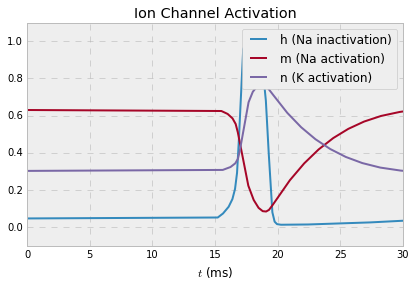

In [225]:
plt.xlabel('$t$ (ms)')
plt.xlim(0, 30)
plt.ylim(-0.1, 1.1)
xticks = [x * dt for x in range(T)]
plt.plot(Time, b)
plt.plot(Time, c)
plt.plot(Time, d)
plt.legend(['h (Na inactivation)', 'm (Na activation)',
            'n (K activation)'], bbox_to_anchor=(1, 1), framealpha=1)
plt.title('Ion Channel Activation')
#plt.savefig('1actv.png', dpi=144)

## Electrical Bursting

In [10]:
vt = mt = nt = ht = 0.
it = [10] * T
vts, hts, mts, nts = ([] for i in range(4))
for t in range(int(100 // dt)):
    vt, ht, mt, nt = update(v=vt, h=ht, m=mt, n=nt, i=0, dt=dt)
for t in range(T):
    vt, ht, mt, nt = update(v=vt, h=ht, m=mt, n=nt, i=it[t], dt=dt)
    vts.append(vt)
    hts.append(ht)
    mts.append(mt)
    nts.append(nt)

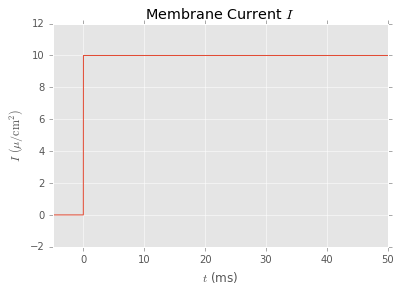

In [11]:
plt.xlabel('$t$ (ms)')
plt.ylabel('$I$ $\mathrm{(\mu/cm^2)}$')
plt.xlim(-5, 50)
plt.ylim(-2, 12)
xticks = [x * dt for x in range(-500, 0)] + [x * dt for x in range(T)]
plt.plot(xticks, [0]*500 + it)
plt.title('Membrane Current $I$')
#plt.savefig('2current.png', dpi=144)

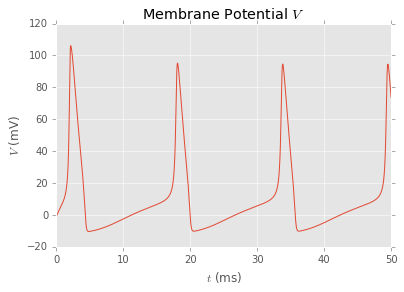

In [12]:
plt.xlabel('$t$ (ms)')
plt.ylabel('$V$ (mV)')
plt.xlim(0, 50)
plt.ylim(-20, 120)
xticks = [x * dt for x in range(T)]
plt.plot(xticks, vts)
plt.title('Membrane Potential $V$')
#plt.savefig('2potential.png', dpi=144)

## Refractory Period

In [13]:
vt = mt = nt = ht = 0.
it = ([10] * 200 + [0] * 800) * (T // 1000)
vts, hts, mts, nts = ([] for i in range(4))
for t in range(int(100 / dt)):
    vt, ht, mt, nt = update(v=vt, h=ht, m=mt, n=nt, i=0, dt=dt)
for t in range(T):
    vt, ht, mt, nt = update(v=vt, h=ht, m=mt, n=nt, i=it[t], dt=dt)
    vts.append(vt)
    hts.append(ht)
    mts.append(mt)
    nts.append(nt)

Text(0.5, 1.0, 'Membrane Current $I$')

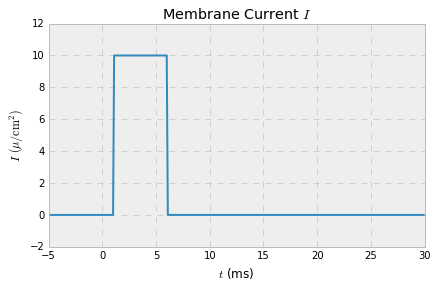

In [43]:
plt.xlabel('$t$ (ms)')
plt.ylabel('$I$ $\mathrm{(\mu/cm^2)}$')
plt.xlim(-5, 30)
plt.ylim(-2, 12)
xticks = [x * dt for x in range(-500, 0)] + [x * dt for x in range(T)]
plt.plot(xticks, [0]*500 + it)
plt.title('Membrane Current $I$')
#plt.savefig('3current.png', dpi=144)

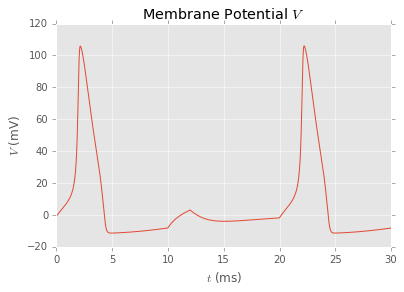

In [15]:
plt.xlabel('$t$ (ms)')
plt.ylabel('$V$ (mV)')
plt.xlim(0, 30)
plt.ylim(-20, 120)
xticks = [x * dt for x in range(T)]
plt.plot(xticks, vts)
plt.title('Membrane Potential $V$')
#plt.savefig('3potential.png', dpi=144)

## Noise Resistance

In [16]:
vt = mt = nt = ht = 0.
it = [np.random.normal() for i in range(T)]
vts, hts, mts, nts = ([] for i in range(4))
for t in range(int(100 / dt)):
    vt, ht, mt, nt = update(v=vt, h=ht, m=mt, n=nt, i=0, dt=dt)
for t in range(T):
    vt, ht, mt, nt = update(v=vt, h=ht, m=mt, n=nt, i=it[t], dt=dt)
    vts.append(vt)
    hts.append(ht)
    mts.append(mt)
    nts.append(nt)

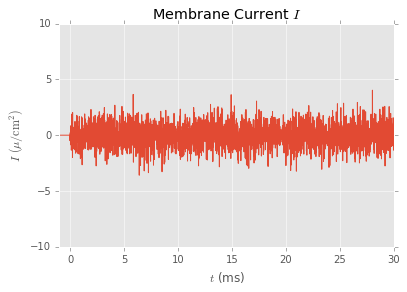

In [17]:
plt.xlabel('$t$ (ms)')
plt.ylabel('$I$ $\mathrm{(\mu/cm^2)}$')
plt.xlim(-1, 30)
plt.ylim(-10, 10)
xticks = [x * dt for x in range(-500, 0)] + [x * dt for x in range(T)]
plt.plot(xticks, [0]*500 + it)
plt.title('Membrane Current $I$')
#plt.savefig('7current.png', dpi=144)

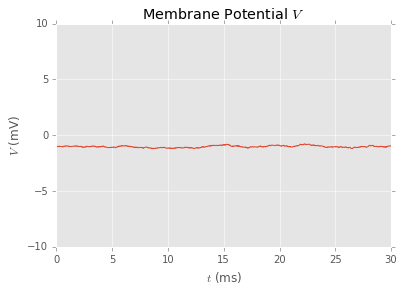

In [18]:
plt.xlabel('$t$ (ms)')
plt.ylabel('$V$ (mV)')
plt.xlim(0, 30)
plt.ylim(-10, 10)
xticks = [x * dt for x in range(T)]
plt.plot(xticks, vts)
plt.title('Membrane Potential $V$')
#plt.savefig('7potential.png', dpi=144)

## Analysis in m-v phase plane

In [19]:
vt = mt = nt = ht = 0.
it = [10] * 500 + [0] * (T - 500)
vts, hts, mts, nts = ([] for i in range(4))
for t in range(int(100 / dt)):
    vt, ht, mt, nt = update(v=vt, h=ht, m=mt, n=nt, i=0, dt=dt)
for t in range(T):
    vt, ht, mt, nt = update(v=vt, h=ht, m=mt, n=nt, i=it[t], dt=dt)
    vts.append(vt)
    hts.append(ht)
    mts.append(mt)
    nts.append(nt)

In [20]:
def m_nullcline(v):
    alpm = 0.1 * (25 - v) / (np.exp((25 - v) / 10) - 1)
    betm = 4. * np.exp(-v / 18)
    m = alpm / (alpm + betm)
    return m

mnc_vs = [x * 0.1 for x in range(-200, 249)] + [x * 0.1 for x in range(251, 1400)]
mnc_ms = [m_nullcline(v) for v in mnc_vs] 

In [21]:
def v_nullcline(m, n, h, i):
    gna = G_na * h * (m**3)
    gk = G_k * (n**4)
    gl = G_l
    v = (gna * V_na + gk * V_k + gl * V_l + i) / (gna + gk + gl)
    return v

p1 = 2500
p2 = 250
p3 = 300
p4 = 400
vnc_ms = [x * 0.001 for x in range(0, 1400)]
vnc_vs1 = [v_nullcline(m, nts[p1], hts[p1], it[p1]) for m in vnc_ms] 
vnc_vs2 = [v_nullcline(m, nts[p2], hts[p2], it[p2]) for m in vnc_ms] 
vnc_vs3 = [v_nullcline(m, nts[p3], hts[p3], it[p3]) for m in vnc_ms] 
vnc_vs4 = [v_nullcline(m, nts[p4], hts[p4], it[p4]) for m in vnc_ms] 

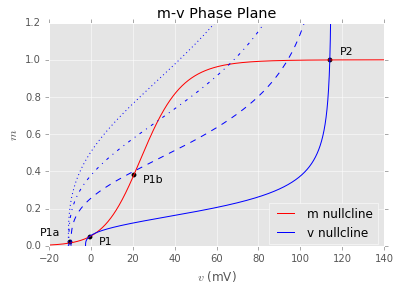

In [22]:
plt.plot(mnc_vs, mnc_ms, color='r')
plt.plot(vnc_vs1, vnc_ms, color='b')
plt.plot(vnc_vs2, vnc_ms, color='b', linestyle='--')
plt.plot(vnc_vs3, vnc_ms, color='b', linestyle='-.')
plt.plot(vnc_vs4, vnc_ms, color='b', linestyle=':')
plt.xlabel('$v$ (mV)')
plt.ylabel('$m$')
plt.xlim(-20, 140)
plt.ylim(0, 1.2)
plt.legend(['m nullcline', 'v nullcline'], 
           bbox_to_anchor=(1, 0.22), framealpha=1)
# fixed point
plt.scatter([-0.732, ], [0.0486, ], 18, color='k', marker='o')
plt.annotate('P1', xy=(-0.732, 0.0486), xycoords='data',
             xytext=(+9, -8), textcoords='offset points', fontsize=11)
plt.scatter([114, ], [1, ], 18, color='k', marker='o')
plt.annotate('P2', xy=(114, 1), xycoords='data',
             xytext=(+10, +5), textcoords='offset points', fontsize=11)
plt.scatter([-10, ], [0.02, ], 18, color='k', marker='o')
plt.annotate('P1a', xy=(-10, 0.02), xycoords='data',
             xytext=(-30, +7), textcoords='offset points', fontsize=11)
plt.scatter([20.5, ], [0.38, ], 18, color='k', marker='o')
plt.annotate('P1b', xy=(20.5, 0.38), xycoords='data',
             xytext=(+9, -7), textcoords='offset points', fontsize=11)
plt.title('m-v Phase Plane')
#plt.savefig('4nullcline.png', dpi=144)

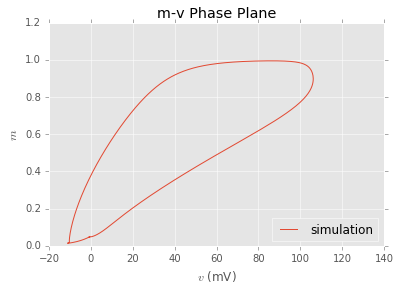

In [23]:
plt.plot(vts[:2500], mts[:2500])
plt.xlabel('$v$ (mV)')
plt.ylabel('$m$')
plt.xlim(-20, 140)
plt.ylim(0, 1.2)
plt.legend(['simulation'], 
           bbox_to_anchor=(1, 0.15), framealpha=1)
plt.title('m-v Phase Plane')
#plt.savefig('4m-v.png', dpi=144)

## Analysis in n - v phase plane

In [24]:
vt = mt = nt = ht = 0.
it = [10] * 500 + [0] * (T - 500)
vts, hts, mts, nts = ([] for i in range(4))
for t in range(int(100 / dt)):
    vt, ht, mt, nt = update(v=vt, h=ht, m=mt, n=nt, i=0, dt=dt)
for t in range(T):
    vt, ht, mt, nt = update(v=vt, h=ht, m=mt, n=nt, i=it[t], dt=dt)
    vts.append(vt)
    hts.append(ht)
    mts.append(mt)
    nts.append(nt)

In [25]:
def n_nullcline(v):
    alpn = 0.01 * (10 - v) / (np.exp((10 - v) / 10) - 1)
    betn = 0.125 * np.exp(-v / 80)
    n = alpn / (alpn + betn)
    return n

nnc_vs = [x * 0.1 for x in range(-200, 99)] + [x * 0.1 for x in range(101, 1400)]
nnc_ns = [n_nullcline(v) for v in nnc_vs] 

In [26]:
def v_nullcline(n, m):
    i = 0.
    h = 0.8 - n
    gna = G_na * h * (m**3)
    gk = G_k * (n**4)
    gl = G_l
    v = (gna * V_na + gk * V_k + gl * V_l + i) / (gna + gk + gl)
    return v

vnc_ns = [x * 0.001 for x in range(0, 1000)]
vnc_vs1 = [v_nullcline(n, mts[2500]) for n in vnc_ns] 
vnc_vs2 = [v_nullcline(n, mts[150]) for n in vnc_ns] 
vnc_vs3 = [v_nullcline(n, mts[200]) for n in vnc_ns] 
vnc_vs4 = [v_nullcline(n, mts[250]) for n in vnc_ns] 

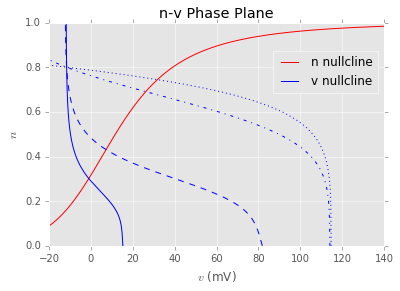

In [27]:
plt.plot(nnc_vs, nnc_ns, color='r')
plt.plot(vnc_vs1, vnc_ns, color='b')
plt.plot(vnc_vs2, vnc_ns, color='b', linestyle='--')
plt.plot(vnc_vs3, vnc_ns, color='b', linestyle='-.')
plt.plot(vnc_vs4, vnc_ns, color='b', linestyle=':')
plt.xlabel('$v$ (mV)')
plt.ylabel('$n$')
plt.xlim(-20, 140)
plt.ylim(0, 1)
plt.legend(['n nullcline', 'v nullcline'], 
           bbox_to_anchor=(1, 0.9), framealpha=1)
plt.title('n-v Phase Plane')
#plt.savefig('5nullcline.png', dpi=144)

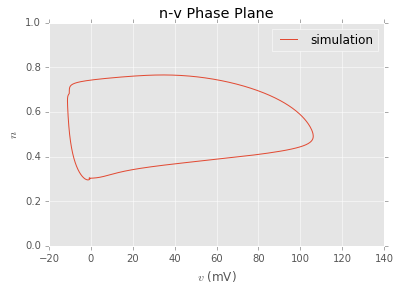

In [28]:
plt.plot(vts[:2500], nts[:2500])
plt.xlabel('$v$ (mV)')
plt.ylabel('$n$')
plt.xlim(-20, 140)
plt.ylim(0, 1)
plt.legend(['simulation'], 
           bbox_to_anchor=(1, 1), framealpha=1)
plt.title('n-v Phase Plane')
#plt.savefig('6n-v.png', dpi=144)